In [2]:
import os
import re
import random
import seaborn
import numpy as np
import pandas as pd
from nltk import tokenize
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import tools
init_notebook_mode()

import numpy as np
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

%matplotlib inline

In [3]:
def getdialogue(textfile):
    dialogue = []
    with open(textfile) as f:
        for index, line in enumerate(f):
            try:
                if tokenize.line_tokenize(line)[0].startswith('\t\t\t\t\t\t'):
                    dialogue.extend(tokenize.line_tokenize(line))
                elif tokenize.line_tokenize(line)[0].startswith('\t\t\t\t'):
                    dialogue.extend(tokenize.line_tokenize(line))
                else:
                    pass
            except:
                pass
    return dialogue

def getlines(dialogue):
    lines = defaultdict(list)
    for index, line in enumerate(dialogue):
        if tokenize.line_tokenize(line)[0].startswith('\t\t\t\t\t\t'):
            k = tokenize.line_tokenize(line)[0].lstrip('\t\t\t\t\t\t')
        if tokenize.line_tokenize(line)[0].startswith('\t\t\t\t'):
            l = tokenize.line_tokenize(line)[0].lstrip('\t\t\t\t')
            if k == l:
                pass
            lines[k].append(l)
            
    for k in lines.keys():
        lines[k] = filter(lambda x: x != k, lines[k])
        lines[k] = ' '.join(lines[k])
        lines[k] = lines[k].replace('! ', '. ').replace('? ', '. ').split('. ')
        lines[k] = filter(lambda x: len(x) > 2, [x.strip() for x in lines[k]])  
    return lines
        
def calcsentiment(character, lines):
    analyzer = SentimentIntensityAnalyzer()
    df = lines[character]
    df_char = pd.DataFrame(columns=['neg', 'neu', 'pos', 'compound', 'line', 'Character'])
    
    row = 0
    for i in df:
        d = analyzer.polarity_scores(i)
        d['line'] = i
        d['Character'] = character
        df_char.loc[row] = d
        row += 1
    
    return [character, row,
            round(df_char[df_char['compound'] != 0.0]['compound'].mean(), 4),
            round(df_char['compound'].mean(),4)], df_char

In [4]:
dialogue = getdialogue('biglebowski.txt')
lines = getlines(dialogue)

lines['BRANDT'] = lines['BRANDT'] + lines.pop('YOUNG MAN')

In [5]:
results = []
dataframes = {}

for i in sorted(lines.keys()):
    row, df = calcsentiment(i, lines)
    results.append(row)
    dataframes[i] = df

data = pd.DataFrame(results, columns=['Character', 'Lines', 'SentimentNoNeutral', 'Sentiment'])
data = data[data['Lines'] > 4].sort_values('Sentiment', ascending=False)
data.head()

Character  Lines  SentimentNoNeutral  Sentiment
38  THE STRANGER     33              0.4312     0.2352
13      DONNELLY     13              0.2818     0.1300
7         BRANDT     65              0.2828     0.1262
36    SECOND MAN      5              0.5106     0.1021
44         VOICE     44              0.2227     0.1012

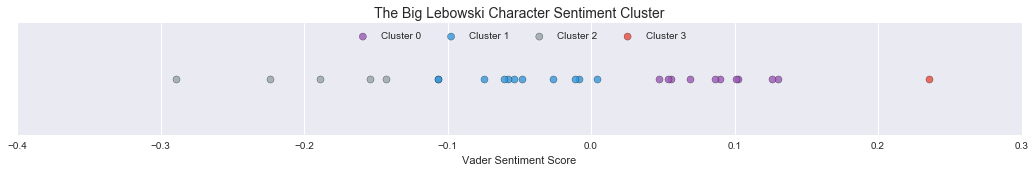

In [6]:
X = data['Sentiment']
km = KMeans(n_clusters=4, random_state=30)
data['KMeans'] = km.fit_predict(X.values.reshape(-1, 1))

# Plot by groups
fig, (ax1) = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 2))
ax1.axes.get_yaxis().set_ticks([])
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c"]

groups = data.groupby('KMeans')
for name, group in groups:
    label = 'Cluster ' + str(name)
    ax1.scatter(group['Sentiment'], np.zeros(group['Sentiment'].shape),
                s=50, alpha=0.8, label=label, c=colors[name])

ax1.set_xlabel('Vader Sentiment Score')
ax1.set_title('The Big Lebowski Character Sentiment Cluster', fontsize = 14)
ax1.legend(ncol=5, loc='upper center')

In [7]:
fig = tools.make_subplots(rows=1, cols=1)

trace1 = go.Scatter(x=[i[0] for i in data['Sentiment'].values.reshape(-1,1)],
                    y=[i[0] for i in np.zeros(len(data['Sentiment'])).reshape(-1,1)],
                    text=map(lambda x: '<br>'.join(x),
                             zip(map(lambda x: x.title(), data['Character']),
                                 map(lambda x: 'Lines: ' + str(x), data['Lines']),
                                 map(lambda x: 'Score: ' + str(x), data['Sentiment']))),
                    hoverinfo='text',
                    marker=dict(color=data['Sentiment'],
                                colorscale=[[0, 'orange'], [1, 'green']],
                                size=np.sqrt(data['Lines'])*4),
                    mode= 'markers',)
fig.append_trace(trace1, 1, 1)
fig['layout'].update(height=350, width=1000,
                     title='The Big Lebowski Sentiment Analysis',
                     showlegend=False, paper_bgcolor="rgb(240, 240, 240)",
                     plot_bgcolor="rgb(240, 240, 240)", 
                     yaxis=dict(autorange=True, showgrid=False, zeroline=True, showticklabels=False,
                                showline=False))
iplot(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



In [9]:
def kde_scatter(character):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1)
    kde = kde.fit(dataframes[character]['compound'].values.reshape(-1,1))
    x_vals = np.arange(-1, 1, 0.001).reshape(-1,1)

    kde_scores = [np.exp(i) for i in kde.score_samples(x_vals)]
    X_range = [i[0] for i in x_vals]

    trace0 = go.Scatter(x=X_range, y=kde_scores, mode='lines', hoverinfo='none',
                        marker=dict(color='k'), name=character.title() + "'s KDE")
    trace1 = go.Scatter(x=map(lambda x: x + np.random.normal(0, 0.01),
                              [i[0] for i in dataframes[character]['compound'].values.reshape(-1,1)]),
                        y=map(lambda x: x + np.random.normal(0, 0.3),
                              [i[0] for i in np.zeros(len(dataframes[character]['compound'])).reshape(-1,1)]),
                        text=map(lambda x: '<br>'.join(x),
                                 zip(map(lambda x: 'Compound Score: ' + str(x), dataframes[character]['compound']),
                                     map(lambda x: 'Line: ' + str(x[:100]) + '<br>' + str(x[100:200])+ '<br>' + str(x[200:300]), dataframes[character]['line']))),
                        hoverinfo='text',
                        marker=dict(color=dataframes[character]['compound'],
                                    colorscale=[[0, 'orange'], [1, 'green']]),
                        mode= 'markers',
                        name=character.title() + "'s Lines")
    return [trace0, trace1]

In [18]:
DUDE = kde_scatter('DUDE')
DONNY = kde_scatter('DONNY')
WALTER = kde_scatter('WALTER')
QUINTANA = kde_scatter('QUINTANA')
LEBOWSKI = kde_scatter('LEBOWSKI')
MAUDE = kde_scatter('MAUDE')
STRANGER = kde_scatter('THE STRANGER')

fig = tools.make_subplots(rows=7, cols=1,
                          subplot_titles=("The Dude", 'Walter','Donny', 'Lebowski', 
                                          'Maude', 'The Stranger', 'Quintana'))
fig.append_trace(DUDE[0], 1, 1)
fig.append_trace(WALTER[1], 2, 1)
fig.append_trace(WALTER[0], 2, 1)
fig.append_trace(DUDE[1], 1, 1)
fig.append_trace(DONNY[0], 3, 1)
fig.append_trace(DONNY[1], 3, 1)
fig.append_trace(LEBOWSKI[0], 4, 1)
fig.append_trace(LEBOWSKI[1], 4, 1)
fig.append_trace(MAUDE[0], 5, 1)
fig.append_trace(MAUDE[1], 5, 1)
fig.append_trace(STRANGER[0], 6, 1)
fig.append_trace(STRANGER[1], 6, 1)
fig.append_trace(QUINTANA[0], 7, 1)
fig.append_trace(QUINTANA[1], 7, 1)
fig['layout'].update(height=1750, width=1000,
                     title='The Big Lebowski Sentiment Analysis, Vader Score KDE',
                     showlegend=False, paper_bgcolor="rgb(240, 240, 240)",
                     plot_bgcolor="rgb(240, 240, 240)", 
                     yaxis1=dict(showticklabels=False, showgrid=False),
                     yaxis2=dict(showticklabels=False, showgrid=False),
                     yaxis3=dict(showticklabels=False, showgrid=False),
                     yaxis4=dict(showticklabels=False, showgrid=False),
                     yaxis5=dict(showticklabels=False, showgrid=False),
                     yaxis6=dict(showticklabels=False, showgrid=False),
                     yaxis7=dict(showticklabels=False, showgrid=False))

iplot(fig, )

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]
[ (4,1) x4,y4 ]
[ (5,1) x5,y5 ]
[ (6,1) x6,y6 ]
[ (7,1) x7,y7 ]

